# Deep Learning
## Summative assessment
### Coursework 2

#### Instructions

This coursework is released on **Wednesday 21st February 9.00** and is due by **Wednesday 6th March 23.59**. It is worth **40%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 10 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for a classification task using multimodal data.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and a PDF submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook and separate PDF file(s) to Coursera by the deadline above.

In [1]:
# You will need the following imports for this assessment. You can make additional imports when you need them

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.keras.layers import (Layer, Input, Dense, GRU, Embedding, Conv2D, BatchNormalization, Activation, GlobalMaxPooling2D)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# You will need access to a GPU for this coursework

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# %cd /content/drive/MyDrive

/content/drive/MyDrive


#### The CLEVR Dataset

This assessment makes use of the [CLEVR Dataset](https://cs.stanford.edu/people/jcjohns/clevr/). This dataset is a visual question answering dataset, and consists of images with corresponding text questions and answers about the image.  

* Johnson, J., Hariharan, B., van der Maaten, L., Li, F.-F., Zitnick, C. L. & Girshick, R. (2016), "CLEVR: A Diagnostic Dataset for Compositional Language and Elementary Visual Reasoning", *IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, 1988-1997.

The original dataset consists of a training set of 70,000 images and 699,989 questions, a validation set of 15,000 images and 149,991 questions, and a test set of 15,000 images and 14,988 questions. In this coursework you will work with a subset of the training and validation splits, which have been preprocessed and prepared for you.

The data is stored in TFRecord format, which is a data format that is efficient for TensorFlow to work with. You can read about the TFRecord format [here](https://www.tensorflow.org/tutorials/load_data/tfrecord) if you are interested, but there is no need to find out about TFRecord for this assessment. The code to read in the TFRecord data to Dataset objects is provided for you below.

In [5]:
train_ds = tf.data.TFRecordDataset([os.path.join('data', 'train', f)
                                    for f in os.listdir(os.path.join('data', 'train')) if f.endswith('tfrecords')])
val_ds = tf.data.TFRecordDataset([os.path.join('data', 'val', f)
                                    for f in os.listdir(os.path.join('data', 'val')) if f.endswith('tfrecords')])

In [6]:
# The following helper function will parse the TFRecord files to return a dictionary of TensorFlow objects

def parse_function(example_proto):
    features = {
        "image": tf.io.FixedLenFeature((), tf.string),
        "question": tf.io.VarLenFeature(dtype=tf.string),
        "answer": tf.io.VarLenFeature(dtype=tf.string)
    }
    parsed_features = tf.io.parse_single_example(serialized=example_proto, features=features)
    parsed_features["question"] = tf.sparse.to_dense(parsed_features["question"])
    parsed_features["answer"] = tf.sparse.to_dense(parsed_features["answer"])
    image = tf.io.decode_raw(parsed_features["image"], tf.int32)
    image = tf.reshape(image, [224, 224, 3])
    parsed_features["image"] = image
    return parsed_features

In [7]:
train_ds = train_ds.map(parse_function)
val_ds = val_ds.map(parse_function)

In [8]:
train_ds.element_spec

{'answer': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'question': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'image': TensorSpec(shape=(224, 224, 3), dtype=tf.int32, name=None)}

Your task in this assessment is to develop a deep learning model to predict the answer for a given question about an image.

You will need to implement special customised layers and a sophisticated model architecture, making use of both CNN and RNN models. You will process the data, train and evaluate the specified model, and then write a proposal for your own modified architecture.

### Question 1 (Total 15 marks)

The training and validation datasets both return dictionaries with keys `"image"`, `"question"` and `"answer"`. For each image, there are multiple questions and answers. The question and answer entries in the dictionary are both lists of strings of the same length, with aligned questions and answers for the given image. The image entry is a 224x224x3 integer Tensor. These images have been resized from the original size of 480x320, so they appear slightly stretched (this can be ignored).

a) Inspect the contents of the dataset by displaying at least one image and it's corresponding questions and answers.

**(3 marks)**

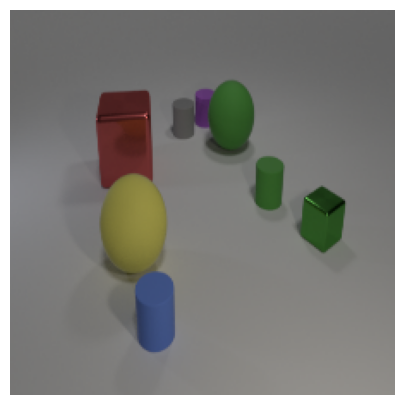

Questions and Answers:
Q: Are the large green ball and the red object made of the same material?
A: no
Q: Are there an equal number of green metallic cubes that are right of the big red metallic block and spheres left of the purple rubber cylinder?
A: yes
Q: There is a green thing that is the same shape as the yellow object; what is its size?
A: large
Q: There is a large matte object that is to the left of the small blue matte thing; what shape is it?
A: sphere
Q: Is the cube that is left of the purple thing made of the same material as the green object that is in front of the tiny green cylinder?
A: yes
Q: What is the shape of the large yellow object?
A: sphere
Q: Are there an equal number of big yellow spheres behind the yellow rubber sphere and gray things?
A: no
Q: There is a ball that is the same color as the small metal object; what size is it?
A: large
Q: Is there a large yellow ball made of the same material as the gray cylinder?
A: yes
Q: Does the big yellow rubber thing that 

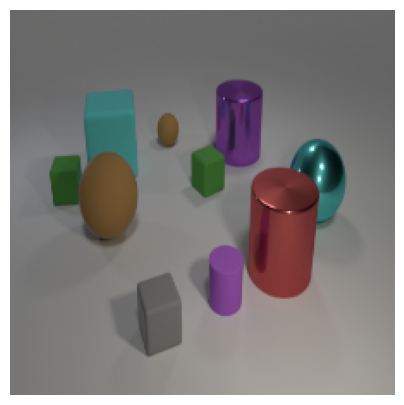

Questions and Answers:
Q: There is a small matte thing that is the same shape as the purple metal object; what color is it?
A: purple
Q: Does the purple cylinder in front of the cyan block have the same material as the large cyan sphere?
A: no
Q: What number of small things are cyan shiny things or yellow metallic things?
A: 0
Q: How big is the purple matte cylinder?
A: small
Q: Is the size of the purple matte cylinder the same as the matte block that is right of the small gray thing?
A: yes
Q: What number of cyan objects are either small cylinders or blocks?
A: 1
Q: What number of big gray things are there?
A: 0
Q: What size is the rubber sphere that is behind the cyan sphere?
A: small
Q: Does the cyan matte object have the same size as the red object?
A: yes
Q: What number of things are either large purple cylinders or matte cubes that are behind the red metallic cylinder?
A: 4


In [9]:
for example_image in train_ds.take(2):
    plt.figure(figsize=(5, 5))
    plt.imshow(example_image["image"])
    plt.axis("off")
    plt.show()

    print("Questions and Answers:")
    for question, answer in zip(example_image["question"], example_image["answer"]):
        print(f"Q: {question.numpy().decode()}")
        print(f"A: {answer.numpy().decode()}")

b) The training and validation Datasets should be processed as follows:

* The image pixel values should be scaled to the interval $[0, 1]$.
* The answers should be (sparse) encoded as integer labels. You will need to compute the total number of distinct answers to do this.
* The questions should be tokenized and represented as a sequence of integer tokens. The questions should be split on whitespace and standardized by lowercasing and removing punctuation.
* A single question-answer pair should be uniformly sampled from the available questions and answers for each image (so each image should appear exactly once per epoch with a single question-answer pair).
* The inputs to the model will be the question and the image. The targets will be the answer. Process the Datasets so that they return a tuple of 2 elements corresponding to inputs and targets.
* Shuffle the training Dataset, and batch both Datasets with batch size 64.

Print out the number of distinct answer labels, as well as the number of tokens in the vocabulary computed from the questions.

Print out the element_spec of one of the Datasets after processing.

**(12 marks)**

In [10]:
def scale_images(feature):
    """Scales image pixel values to the interval [0, 1]."""
    feature["image"] = tf.cast(feature["image"], tf.float32) / 255.0

    return feature

Gather the unique answers from the training dataset, and build answer vocabulary:

In [11]:
all_answers = []
for features in train_ds:
    all_answers.extend([a.numpy().decode() for a in features["answer"]])
unique_answers = set(all_answers)
answer_lookup = tf.keras.layers.StringLookup(output_mode="int")
answer_lookup.set_vocabulary(sorted(unique_answers), idf_weights=None)

In [12]:
def encode_answers(feature):
    """Encodes answers as integer labels."""
    feature["answer"] = answer_lookup(feature["answer"])

    return feature

Define TextVectorization layer for questions tokenization:

In [13]:
output_sequence_length = 42  # calculation was done once separately in the commented cell below
vectorize_layer = tf.keras.layers.TextVectorization(
    output_sequence_length=output_sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
)

In [14]:
# a dataset of questions for adapting the layer
questions_dataset = train_ds.map(lambda x: x["question"])
vectorize_layer.adapt(questions_dataset)

In [15]:
# def find_max_length(ds):
#     max_length = 0
#     for text in ds:
#         vectorized_text = vectorize_layer(tf.expand_dims(text, -1))
#         max_length = max(max_length, vectorized_text.shape[1])
#     return max_length

# max_length = find_max_length(questions_dataset)
# print(f"Maximum sequence length: {max_length}")

In [16]:
def tokenize_questions(feature):
    """Tokenizes questions using TextVectorization layer."""
    feature["question"] = vectorize_layer(feature["question"])
    feature["question"] = tf.cast(feature["question"], tf.int32)

    return feature

Uniformly sample a single question-answer pair:

In [17]:
def sample_one_qa_pair(feature):
    sampled_index = tf.random.uniform(
        shape=[], maxval=tf.shape(feature["question"])[0], dtype=tf.int32
    )
    question = tf.gather(feature["question"], sampled_index)
    answer = tf.gather(feature["answer"], sampled_index)

    return {"image": feature["image"], "question": question}, answer

In [18]:
train_ds = (
    train_ds.map(scale_images)
    .map(encode_answers)
    .map(tokenize_questions)
    .map(sample_one_qa_pair)
)
val_ds = (
    val_ds.map(scale_images)
    .map(encode_answers)
    .map(tokenize_questions)
    .map(sample_one_qa_pair)
)

Shuffle the training Dataset, and batch both Datasets with batch size 64:

In [19]:
train_ds = train_ds.shuffle(1000).batch(64)
val_ds = val_ds.batch(64)

In [20]:
num_classes = answer_lookup.vocabulary_size()
print(f"Number of distinct answer labels: {num_classes} including 1 OOV token")

Number of distinct answer labels: 29 including 1 OOV token


In [21]:
vocab_size = vectorize_layer.vocabulary_size()
print(f"Number of tokens in the vocabulary: {vectorize_layer.vocabulary_size()} including ' ' and '[UNK]'")

Number of tokens in the vocabulary: 82 including ' ' and '[UNK]'


In [22]:
train_ds.element_spec

({'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  'question': TensorSpec(shape=(None, 42), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [23]:
val_ds.element_spec

({'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  'question': TensorSpec(shape=(None, 42), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

### Question 2 (Total 35 marks)

The model that you will implement for the visual question answering task was first proposed in the paper

* Perez, E., Strub, F., de Vries, H. & Courville, A. (2018), "FiLM: visual reasoning with a general conditioning layer", in _Proceedings of the Thirty-Second AAAI Conference on Artificial Intelligence_, New Orleans, Louisiana, USA.

The main idea is the introduction of a specialised layer called a FiLM layer (Feature-wise Linear Modulation). The purpose of this layer is to modify the predictions that are made by a CNN prediction model (the central stack coloured in brown in the figure below). The CNN prediction model takes the image as input, and outputs a categorical distribution over the set of possible answers.

The FiLM layer uses information stored in a vector embedding (which comes from the question text) to modify the post-activations of the CNN prediction model. This vector embedding is produced by a gated recurrent unit (GRU) network (referred to in the original paper as the FiLM generator) as the final hidden layer representation after processing the input question. This vector embedding is also referred to as the conditioning signal.

The overall model architecture is shown in the figure below:

<center><img src="figures/model.png" alt="Model architecture" style="width: 450px;"/></center>
<center>Overall model architecture</center>

The question is tokenized, and learned embeddings are processed sequentially by the GRU network/FiLM generator. There are potentially multiple FiLM layers within the CNN prediction model. Each FiLM layer uses the GRU embedding $\mathbf{q}$ (the conditioning signal) to modify the output of a convolutional layer within the CNN prediction model, as described in part c).

a) Implement the FiLM generator as a 2-layer stacked GRU network, using an embedding dimension of 64, and 128 neurons for both of the layers of the GRU. The network should output the final 128-dimensional embedding. Print the model summary.

**(3 marks)**

In [24]:
class FiLMGenerator(Model):
    def __init__(self, embedding_dim, gru_units, vocab_size, output_sequence_length):
        super(FiLMGenerator, self).__init__()
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=output_sequence_length,
        )
        self.gru_1 = GRU(gru_units, return_sequences=True)
        self.gru_2 = GRU(gru_units, return_sequences=False)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.gru_1(x)
        x = self.gru_2(x)

        return x

In [25]:
embedding_dim = 64
gru_units = 128
film_generator = FiLMGenerator(embedding_dim, gru_units, vocab_size, output_sequence_length)
dummy_input = tf.zeros([1, output_sequence_length], dtype=tf.int32)
film_generator(dummy_input)
film_generator.summary()

Model: "fi_lm_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  5248      
                                                                 
 gru (GRU)                   multiple                  74496     
                                                                 
 gru_1 (GRU)                 multiple                  99072     
                                                                 
Total params: 178816 (698.50 KB)
Trainable params: 178816 (698.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


b) The first block of the CNN prediction model is a feature extractor CNN which does not make use of the conditioning signal $\mathbf{q}$ from the GRU network. This block takes the image as input, and passes it through two sub-blocks, each consisting of the following layers:

* A 2D convolutional layer with 128 filters, a 4x4 kernel, 2x2 strides, 'SAME' padding, and no activation function
* A batch normalisation layer
* An element-wise ReLU activation

Implement the feature extractor CNN and print the model summary.

**(2 marks)**

In [26]:
class FeatureExtractorCNN(Model):
    def __init__(self, **kwargs):
        super(FeatureExtractorCNN, self).__init__(**kwargs)
        # first sub-block
        self.conv_1 = Conv2D(
            128, kernel_size=(4, 4), strides=(2, 2), padding="SAME", activation=None
        )
        self.bn_1 = BatchNormalization()
        self.relu_1 = tf.keras.layers.ReLU()

        # second sub-block
        self.conv_2 = Conv2D(
            128, kernel_size=(4, 4), strides=(2, 2), padding="SAME", activation=None
        )
        self.bn_2 = BatchNormalization()
        self.relu_2 = tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = self.relu_1(x)

        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)

        return x

In [27]:
feature_extractor_cnn = FeatureExtractorCNN()
dummy_input = tf.random.normal([1, 224, 224, 3])
feature_extractor_cnn(dummy_input)
feature_extractor_cnn.summary()

Model: "feature_extractor_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  6272      
                                                                 
 batch_normalization (Batch  multiple                  512       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  262272    
                                                                 
 batch_normalization_1 (Bat  multiple                  512       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              multiple        

c) Implement a custom layer class for the FiLM layer as described below. This class should subclass the base `Layer` class in the `tensorflow.keras.layers` module.

This layer will need to take two inputs when it is called: the conditioning signal $\mathbf{q}$, as well as the previous convolutional layer output $\mathbf{h}$.

The FiLM layer passes the conditioning signal $\mathbf{q}$ output by the GRU FiLM generator through a linear layer (dense layer with no activation function) to produce $\gamma$ and $\beta$:

$$
\gamma = \textrm{Linear}(\mathbf{q}) \quad\quad \beta = \textrm{Linear}(\mathbf{q}).
$$

Both $\gamma$ and $\beta$ are vectors, with length equal to the number of feature maps (or channels) in the output of a convolutional layer $\mathbf{h}$. These post-activations are then modulated via the feature-wise affine transformation:

$$
\textrm{FiLM}(\mathbf{h} | \gamma, \beta)_{h, w, c} = \gamma_c \mathbf{h}_{h, w, c} + \beta_c,
$$
where the subscripts $h, w, c$ index the height, width and channel dimensions respectively.

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(10 marks)**

In [28]:
class FiLMLayer(Layer):
    def __init__(self, **kwargs):
        super(FiLMLayer, self).__init__(**kwargs)
        # initialize dense layers
        self.dense_gamma = None
        self.dense_beta = None

    def build(self, inputs):
        # inputs[1] is the shape of h
        # set the units based on the number of feature maps in h
        feature_maps = inputs[1][-1]
        self.dense_gamma = Dense(units=feature_maps, use_bias=False)
        self.dense_beta = Dense(units=feature_maps, use_bias=False)
        super(FiLMLayer, self).build(inputs)

    def call(self, inputs):
        q, h = inputs
        # generate parameters
        gamma = self.dense_gamma(q)
        beta = self.dense_beta(q)
        # adjust shapes
        gamma = tf.expand_dims(tf.expand_dims(gamma, 1), 1)
        beta = tf.expand_dims(tf.expand_dims(beta, 1), 1)

        return gamma * h + beta

In [29]:
film_layer = FiLMLayer()
dummy_h = tf.random.normal((1, 56, 56, 128))
dummy_q = tf.random.normal((1, 128))
output = film_layer([dummy_q, dummy_h])
print(output.shape)

(1, 56, 56, 128)


d) The second main block of the CNN network consists of a number of ResBlocks. Each ResBlock consists of the following layers:

<center><img src="figures/resblock.png" alt="ResBlock" style="width: 150px;"/></center>


* A 1x1 convolutional layer with 128 channels and ReLU activation function
* A 3x3 convolutional layer with 128 channels and no activation function
* A BatchNormalization layer, where the usual $\gamma$ and $\beta$ parameters are not used
* a FiLM layer, that also uses the conditioning signal $\mathbf{q}$ from the GRU network
* An elementwise ReLU activation function
* The output is then added to the output of the first convolutional layer

Each convolutional layer uses 'SAME' padding.

Implement the ResBlock as another custom layer. Similar to the FiLM layer, this layer will also need to take two inputs when it is called: the conditioning signal $\mathbf{q}$, as well as the previous convolutional layer output $\mathbf{h}$.

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(8 marks)**

In [30]:
class ResBlock(Layer):
    def __init__(self, channels, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.channels = channels
        self.conv_1 = Conv2D(
            channels, kernel_size=1, strides=1, padding="SAME", activation="relu"
        )
        self.conv_2 = Conv2D(
            channels, kernel_size=3, strides=1, padding="SAME", use_bias=False
        )
        self.bn = BatchNormalization(scale=False, center=False)
        self.film = FiLMLayer()
        self.relu = tf.keras.layers.ReLU()
        self.add = tf.keras.layers.Add()

    def call(self, inputs):
        q, previous_output_h = inputs
        x = self.conv_1(previous_output_h)
        residual = x  # save the output to add after the second conv
        x = self.conv_2(x)
        x = self.bn(x)
        x = self.film([q, x])
        x = self.relu(x)
        x = self.add([x, residual])

        return x

In [31]:
res_block = ResBlock(128)
dummy_conditioning_signal = tf.random.normal([1, 128])
dummy_previous_output_h = tf.random.normal([1, 56, 56, 128])
output = res_block([dummy_conditioning_signal, dummy_previous_output_h])
print(output.shape)

(1, 56, 56, 128)


e) At several points in the model, two coordinate feature maps will be added to the output of a convolutional layer. This operation will be applied before each ResBlock and the classifier component of the CNN prediction model.

These two feature maps indicate relative $x$ and $y$ spatial position, and are each scaled from $-1$ to $1$ across the height and width dimensions. These two feature maps are concatenated as two extra channels to the convolutional layer output.

Implement this operation as another custom layer class called `AddSpatialCoordinates`. The layer should be able to accept input Tensors with arbitrary height, width and channel dimensions. This custom layer will not have any trainable variables.

Create an instance of your custom layer class and test it on some dummy inputs to verify it works as expected.

**(7 marks)**

In [32]:
class AddSpatialCoordinates(Layer):
    def call(self, input):
        batch_size, height, width, channels = (
            tf.shape(input)[0],
            tf.shape(input)[1],
            tf.shape(input)[2],
            tf.shape(input)[3],
        )

        x_map = tf.linspace(-1.0, 1.0, width)
        y_map = tf.linspace(-1.0, 1.0, height)
        # adjust shapes
        x_map = tf.reshape(x_map, (1, 1, width, 1))
        y_map = tf.reshape(y_map, (1, height, 1, 1))
        # adjust to same batch size as the input
        x_map = tf.tile(x_map, [batch_size, height, 1, 1])
        y_map = tf.tile(y_map, [batch_size, 1, width, 1])

        return tf.concat([input, x_map, y_map], axis=-1)

In [33]:
add_spatial_coordinates = AddSpatialCoordinates()
dummy_input = tf.random.normal([1, 56, 56, 128])
output = add_spatial_coordinates(dummy_input)
print(output.shape)

(1, 56, 56, 130)


f) The final main block of the CNN network is a classifier block. This block consists of the following layers:

* 1x1 convolution with 512 output channels, ReLU activation, and 'SAME' padding
* Global max pooling across height and width dimensions
* Dense layer with 512 neurons and ReLU activation
* Final Dense layer with $n_c$ neurons and softmax activation, where $n_c$ is the number of output labels

Once you have implemented the classifier, you should bring all components together to build the complete model. This model consists of the following:

* GRU FiLM generator as defined in part a) that processes the sequence of question tokens and outputs an embedding $\mathbf{q}$ of dimension 128
* Feature extractor block as defined in part b) that processes the input image
* The output of the feature extractor should then be extended with spatial coordinate feature maps by passing it through your `AddSpatialCoordinates` layer
* This should be followed by just one ResBlock custom layer, that takes in two inputs: the output from the previous `AddSpatialCoordinates` layer and the question embedding $\mathbf{q}$. We will only use one ResBlock due to computational limitations
* The output of the ResBlock should then also be extended with spatial coordinate feature maps by passing it through your `AddSpatialCoordinates` layer
* The output from the previous `AddSpatialCoordinates` layer should then be sent through the classifier block to obtain the final output prediction

Implement the complete model according to the above spec, and print the model summary.

**(5 marks)**

In [34]:
class ClassifierBlock(Layer):
    def __init__(self, num_classes, **kwargs):
        super(ClassifierBlock, self).__init__(**kwargs)
        self.conv = Conv2D(512, kernel_size=1, activation="relu", padding="SAME")
        self.global_max_pool = GlobalMaxPooling2D()
        self.dense_1 = Dense(512, activation="relu")
        self.dense_2 = Dense(num_classes, activation="softmax")

    def call(self, input):
        x = self.conv(input)
        x = self.global_max_pool(x)
        x = self.dense_1(x)
        x = self.dense_2(x)

        return x

In [35]:
class QAModel(Model):
    def __init__(
        self,
        vocab_size,
        num_classes,
        embedding_dim=64,
        gru_units=128,
        output_sequence_length=42,
        **kwargs
    ):
        super(QAModel, self).__init__(**kwargs)
        self.film_generator = FiLMGenerator(
            embedding_dim, gru_units, vocab_size, output_sequence_length
        )
        self.feature_extractor = FeatureExtractorCNN()
        self.add_spatial_coordinates_1 = AddSpatialCoordinates()
        self.res_block = ResBlock(128)
        self.add_spatial_coordinates_2 = AddSpatialCoordinates()
        self.classifier = ClassifierBlock(num_classes)

    def call(self, inputs):
        image, question = inputs["image"], inputs["question"]
        q_embedding = self.film_generator(question)
        features = self.feature_extractor(image)
        features_with_coords1 = self.add_spatial_coordinates_1(features)
        resblock_output = self.res_block([q_embedding, features_with_coords1])
        resblock_output_with_coords = self.add_spatial_coordinates_2(resblock_output)

        return self.classifier(resblock_output_with_coords)

In [36]:
model = QAModel(vocab_size, num_classes)
dummy_image = tf.random.normal([1, 224, 224, 3])
# dummy question tensor with random indices within the vocabulary range
dummy_question = tf.random.uniform(
    (1, output_sequence_length), minval=0, maxval=vocab_size, dtype=tf.int32
)
model({"image": dummy_image, "question": dummy_question})
model.summary()

Model: "qa_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fi_lm_generator_1 (FiLMGen  multiple                  178816    
 erator)                                                         
                                                                 
 feature_extractor_cnn_1 (F  multiple                  269568    
 eatureExtractorCNN)                                             
                                                                 
 add_spatial_coordinates_1   multiple                  0         
 (AddSpatialCoordinates)                                         
                                                                 
 res_block_1 (ResBlock)      multiple                  197248    
                                                                 
 add_spatial_coordinates_2   multiple                  0         
 (AddSpatialCoordinates)                                  

### Question 3 (Total 30 marks)

a) You should now train your model from question 2 using a cross entropy loss function. Train the model for 20 epochs, with an Adam optimizer with learning rate 3e-4. You should track model performance on the validation set, including the accuracy.

Your code should be structured to account for restarting broken training runs. You will need to save your model every epoch, and save all of the model's training and validation performance up to that point (a convenient method is to use the `CSVLogger` callback). In the case of a broken training run, the required data should be loaded, and the training run resumed from the last saved checkpoint. You do not need to use early stopping in the training run.

When training has completed, compute and print the final evaluation of your model on the validation set.

_NB: The model would need to be larger and trained for longer to achieve good performance on this task. The model and training have been scaled down to accommodate infrastructure limitations on the Coursera platform. You should implement the architecture as specified in this assessment, but you can train the model for longer if you wish. The performance of the resulting model is **not** part of the marking criteria._

**(15 marks)**

In [37]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

checkpoint_dir = "./checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Directory '{checkpoint_dir}' created")
model_name = "model_epoch_{epoch:02d}"
checkpoint_path = os.path.join(checkpoint_dir, model_name)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor="val_accuracy",
)

# save training and validation logs
csv_logger = CSVLogger(os.path.join(checkpoint_dir, "training_log.csv"), append=True)

Directory './checkpoints' created


In [38]:
def find_latest_checkpoint(checkpoint_dir):
    checkpoint_dirs = [
        d
        for d in os.listdir(checkpoint_dir)
        if os.path.isdir(os.path.join(checkpoint_dir, d))
    ]
    if not checkpoint_dirs:
        return None
    # Assuming the directory names include 'model_epoch_xx'
    latest_dir = max(checkpoint_dirs, key=lambda x: int(x.split("_")[-1]))
    return os.path.join(checkpoint_dir, latest_dir)

In [39]:
latest_checkpoint = find_latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    starting_epoch = int(latest_checkpoint.split("_")[-1])
    print(f"Resuming training from {latest_checkpoint}")
    model = tf.keras.models.load_model(latest_checkpoint)
else:
    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    starting_epoch = 0

In [40]:
epochs = 20
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    initial_epoch=starting_epoch,
    callbacks=[model_checkpoint_callback, csv_logger],
)

Epoch 1/20
234/234 [==============================] - 157s 622ms/step - loss: 2.6680 - accuracy: 0.2047 - val_loss: 2.7236 - val_accuracy: 0.2192
Epoch 2/20
234/234 [==============================] - 24s 98ms/step - loss: 2.6427 - accuracy: 0.2064 - val_loss: 2.6620 - val_accuracy: 0.1907
Epoch 3/20
234/234 [==============================] - 23s 95ms/step - loss: 2.6508 - accuracy: 0.2033 - val_loss: 2.6432 - val_accuracy: 0.2168
Epoch 4/20
234/234 [==============================] - 24s 97ms/step - loss: 2.6225 - accuracy: 0.2058 - val_loss: 2.5865 - val_accuracy: 0.2131
Epoch 5/20
234/234 [==============================] - 23s 96ms/step - loss: 2.6263 - accuracy: 0.2037 - val_loss: 2.4667 - val_accuracy: 0.2133
Epoch 6/20
234/234 [==============================] - 24s 97ms/step - loss: 1.8111 - accuracy: 0.3086 - val_loss: 1.6148 - val_accuracy: 0.3355
Epoch 7/20
234/234 [==============================] - 24s 98ms/step - loss: 1.3153 - accuracy: 0.3847 - val_loss: 1.2329 - val_accurac

In [41]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

59/59 [==============================] - 3s 46ms/step - loss: 1.0216 - accuracy: 0.4104
Validation loss: 1.0216310024261475, Validation accuracy: 0.41040000319480896


b) Plot the loss and accuracy over the course of training on the training and validation sets.

Select at least one sample image and question from the validation set, and compute the model predictions. Display the image, question, ground truth answer and model predictive distribution over the set of answers.

**(7 marks)**

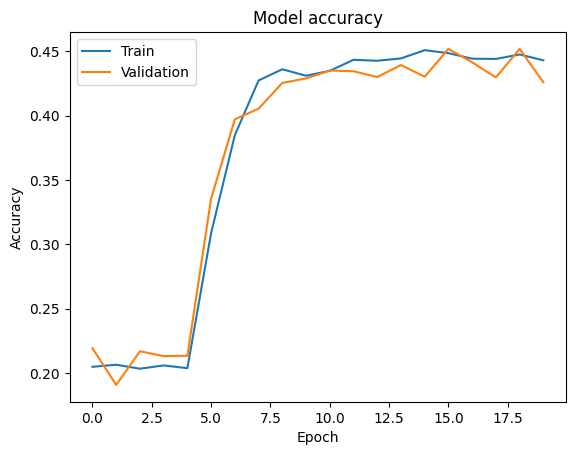

In [42]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

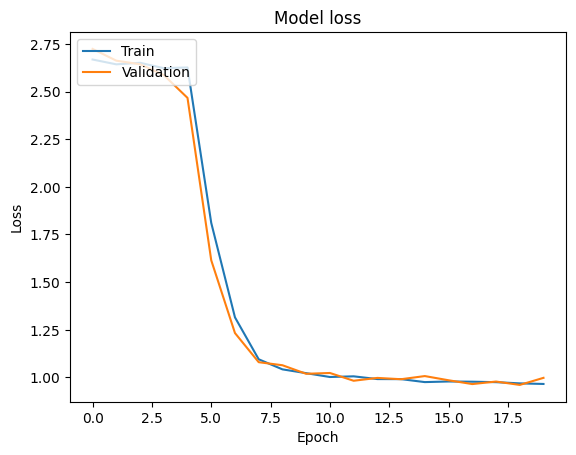

In [43]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [44]:
for input, target in val_ds.take(1):
    image = input["image"][:1]
    question = input["question"][:1]
    target = target[:1]

In [45]:
predictions = model.predict({'image': image, 'question': question})

1/1 [==============================] - 1s 979ms/step


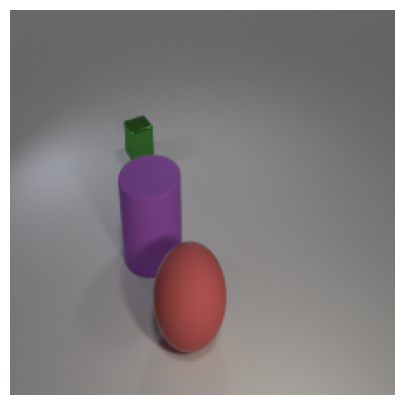

In [46]:
plt.figure(figsize=(5, 5))
plt.imshow(image.numpy()[0])
plt.axis('off')
plt.show()

In [47]:
" ".join([vectorize_layer.get_vocabulary()[i] for i in question.numpy()[0]])

'what number of large things are either purple rubber objects or green shiny things                            '

In [48]:
inverse_answ = dict(enumerate(answer_lookup.get_vocabulary()))
print(f"Ground Truth Answer: {[inverse_answ[i] for i in target.numpy()][0]}")

Ground Truth Answer: 1


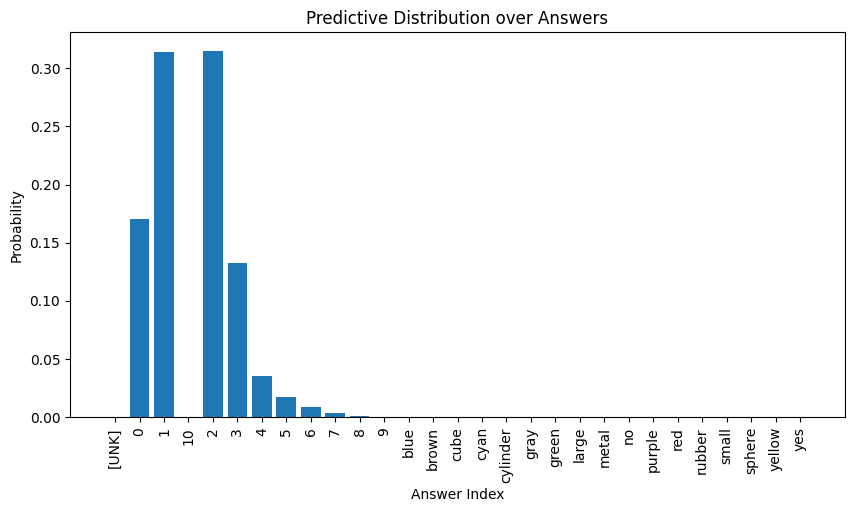

In [49]:
plt.figure(figsize=(10, 5))
plt.bar(answer_lookup.get_vocabulary(), predictions[0])
plt.title("Predictive Distribution over Answers")
plt.xlabel("Answer Index")
plt.ylabel("Probability")
plt.xticks(rotation=90)
plt.show()

c) Explain why adding spatial coordinate feature maps as in 2e) is beneficial for the proposed model and task from questions 1 and 2.

**(3 marks)**

Adding spatial coordinate feature maps may significantly enhance the model's ability to perform visual reasoning and answer questions about images. Doing so we explicitly encode spatial information about each pixel's location within the image. CNNs do not inherently possess an understanding of absolute spatial positions due to their translation-invariant nature. By adding spatial coordinate feature maps, the model gains explicit information about the location of objects within the image, which is crucial for answering questions that depend on understanding spatial relationships such as "What is the object to the left of the red sphere?". There are tasks focusing on specific parts of an image to answer a question for which adding spatial coordinates provide valuable cues that can help the model learn where to "look". Such coordinates may help with questions involving complex reasoning about spatial arrangements and relationships, making it easier for the model to understand and reason about these arrangements, thereby enhancing its ability to handle a wider range of questions. This spatial encoding provides a consistent framework for understanding geometry and positioning, independent of the specific objects involved, leading to the model being able to better generalize to novel scenes or configurations it hasn't encountered during training. In summary, this enhancement is beneficial for tasks requiring detailed visual reasoning, attention to specific image regions, and integration of visual information with questions or commands expressed in text, as in our task.

d) An alternative method to FiLM to incorporate conditioning information would be to concatenate the conditional embedding $\mathbf{q}$ with the channel dimension in a convolutional layer input $\mathbf{h}^{(k-1)}$ at every spatial location (in other words, concatenate constant feature maps with the input $\mathbf{h}^{(k-1)}$ to a convolutional layer).

Explain how this method would compare in terms of computation and parameter efficiency with applying the FiLM layer computation outlined in 2c) to the output $\mathbf{h}^{(k)}$ of the convolutional layer. You can assume the convolutional layer has no activation function.

**(5 marks)**

**Concatenation Method:**

Concatenating $\mathbf{q}$ with $\mathbf{h}^{(k-1)}$ would increase the channel dimension of the convolutional layer's input, meaning the number of computations would increase proportionally to the size of $\mathbf{q}$, as the convolution operation's complexity is directly related to the input channel depth. Hence, as the weight matrix would grow with the number of input channels, the method would require a higher number of parameters in the convolutional layer that processes the concatenated input. If there are multiple concatenations, a significant increase in the model's paramter count would follow. While this method directly infuses the conditioning signal into the convolutional process, it does so in a rigid manner that scales the parameter count and computation with the embedding size.

**FiLM Method:**

The FiLM method applies a feature-wise affine transformation to $\mathbf{h}^{(k)}$, and the computation involves only scaling and addition operations on the feature maps, which are parameterized by the much smaller set of $\gamma$ and $\beta$ coefficients generated from $\mathbf{q}$. Hence, the generation of $\gamma$ and $\beta$ does not significantly increase the overall parameter count of the model, and is more parameter-efficient compared to the concatenation method. Moreover, the convolutional layers' weights do not increase with the size of $\mathbf{q}$, as FiLM modulates the convolutional output rather than its input.

### Question 4 (Total 10 marks)

Provide a separate PDF report with your evaluation and conclusions on the model and training results in this assessment.

In addition, compare the experiment conducted in this assessment with that described in section 2 of the [original paper](https://arxiv.org/abs/1709.07871). In particular, discuss how the model architecture and training algorithm differ.

Your report should be no more than 1 page.

**(10 marks)**